<a href="https://colab.research.google.com/github/Hiranmai-T/Assignment5/blob/master/Copy_of_PersonAttrubutes2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [2]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model,Sequential
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [3]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [55]:
!pip install pillow

In [0]:
import cv2
from PIL import Image
images = []
for i in range(len(df['image_path'])):
  image = cv2.imread(df['image_path'][i])
  image = image.astype('float32')/255
  images.append(image)

In [0]:
df.append(images)

In [37]:
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."


In [4]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [5]:
one_hot_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
0,resized/1.jpg,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
1,resized/2.jpg,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
2,resized/3.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0
3,resized/4.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,resized/5.jpg,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0


In [6]:
one_hot_df.shape

(13573, 28)

In [7]:
one_hot_df['image_path'][0]

'resized/1.jpg'

In [0]:
df2 = one_hot_df.drop(['image_path'], axis=1)

In [9]:
df2.head()

,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
2,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0
3,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0


In [13]:
import numpy as np

image = np.stack([cv2.imread(one_hot_df['image_path'][0])])
type(image)

numpy.ndarray

In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        image = image.astype('float32')/255
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [45]:
from sklearn.model_selection import train_test_split
train_df, val_df,train_label,val_label = train_test_split(one_hot_df['image_path'],df2, test_size=0.15)
train_df.shape, val_df.shape

((11537,), (2036,))

In [46]:
train_df.head()

5147     [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
11833    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
7214     [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
1894     [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
13441    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
Name: image_path, dtype: object

In [0]:
train_df2, val_df2 = train_test_split(one_hot_df, test_size=0.15)

In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df2, batch_size=32)
valid_gen = PersonDataGenerator(val_df2, batch_size=64, shuffle=False)

In [49]:
type(train_gen)

__main__.PersonDataGenerator

In [17]:

# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
backbone = VGG16(
    weights="imagenet", 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

neck = backbone.output
print(neck.shape)
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)
print(neck.shape)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

In [24]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Conv2D
input_shape = (224, 224, 3)
backbone = Sequential()
backbone.add(Convolution2D(64, (3, 3),input_shape=input_shape, padding='same', activation='relu'))
backbone.add(Convolution2D(64, (3, 3), activation='relu', padding='same'))
backbone.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
backbone.add(Convolution2D(128, (3, 3), activation='relu', padding='same'))
backbone.add(Convolution2D(128, (3, 3), activation='relu', padding='same'))
backbone.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
backbone.add(Convolution2D(256, (3, 3), activation='relu', padding='same'))
backbone.add(Convolution2D(256, (3, 3), activation='relu', padding='same'))
backbone.add(Convolution2D(256, (3, 3), activation='relu', padding='same'))
backbone.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
backbone.add(Convolution2D(512, (3, 3), activation='relu', padding='same'))
backbone.add(Convolution2D(512, (3, 3), activation='relu', padding='same'))
backbone.add(Convolution2D(512, (3, 3), activation='relu', padding='same'))
backbone.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
backbone.add(Convolution2D(512, (3, 3), activation='relu', padding='same'))
backbone.add(Convolution2D(512, (3, 3), activation='relu', padding='same'))
backbone.add(Convolution2D(512, (3, 3), activation='relu', padding='same'))
backbone.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#backbone.add(Flatten())
#backbone.add(Dense(4096, activation='relu'))
#backbone.add(Dense(4096, activation='relu'))

#backbone.add(Dense(2048, activation='relu'))
#backbone.add(Dense(1024, activation='relu'))
#backbone.add(Dense(512, activation='relu'))
backbone.add(Dense(1000, activation='relu'))


#backbone.add(Flatten())

neck = backbone.output
print(neck.shape)
neck = Flatten()(neck)
neck = Dense(512, activation="relu")(neck)
print(neck.shape)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

(?, 7, 7, 1000)
(?, 512)


In [0]:
# freeze backbone
#for layer in backbone.layers:
	#layer.trainable = False

In [0]:
# losses = {
# 	"gender_output": "binary_crossentropy",
# 	"image_quality_output": "categorical_crossentropy",
# 	"age_output": "categorical_crossentropy",
# 	"weight_output": "categorical_crossentropy",

# }
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = SGD(lr=0.001, momentum=0.9)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [26]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_14_input (InputLayer)    (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 224, 224, 64) 1792        conv2d_14_input[0][0]            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_14[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_15[0][0]                  
____________________________________________________________________________________________

In [0]:
# model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=10)

In [27]:
datagen = ImageDataGenerator(rescale=1.0/255.0)


# train the model
#  model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
#                                  samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
#                                  validation_data = (test_features, test_labels), verbose=1)
# Train the model
model.fit_generator(
    #generator=train_gen,
    generator = train_gen,
    validation_data = valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=24,
    verbose=1
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/24





359/360 [============================>.] - ETA: 0s - loss: 8.0636 - gender_output_loss: 0.6909 - image_quality_output_loss: 0.9982 - age_output_loss: 1.4500 - weight_output_loss: 1.0315 - bag_output_loss: 0.9403 - footwear_output_loss: 1.0481 - pose_output_loss: 0.9495 - emotion_output_loss: 0.9551 - gender_output_acc: 0.5427 - image_quality_output_acc: 0.5502 - age_output_acc: 0.3974 - weight_output_acc: 0.6332 - bag_output_acc: 0.5608 - footwear_output_acc: 0.4389 - pose_output_acc: 0.6133 - emotion_output_acc: 0.7102

360/360 [==============================] - 123s 343ms/step - loss: 8.0641 - gender_output_loss: 0.6909 - image_quality_output_loss: 0.9986 - age_output_loss: 1.4497 - weight_output_loss: 1.0321 - bag_output_loss: 0.9401 - footwear_output_loss: 1.0480 - pose_output_loss: 0.9497 - emotion_output_loss: 0.9551 - gender_output_acc: 0.5426 - image_quality_output_a

In [0]:
model.summary()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

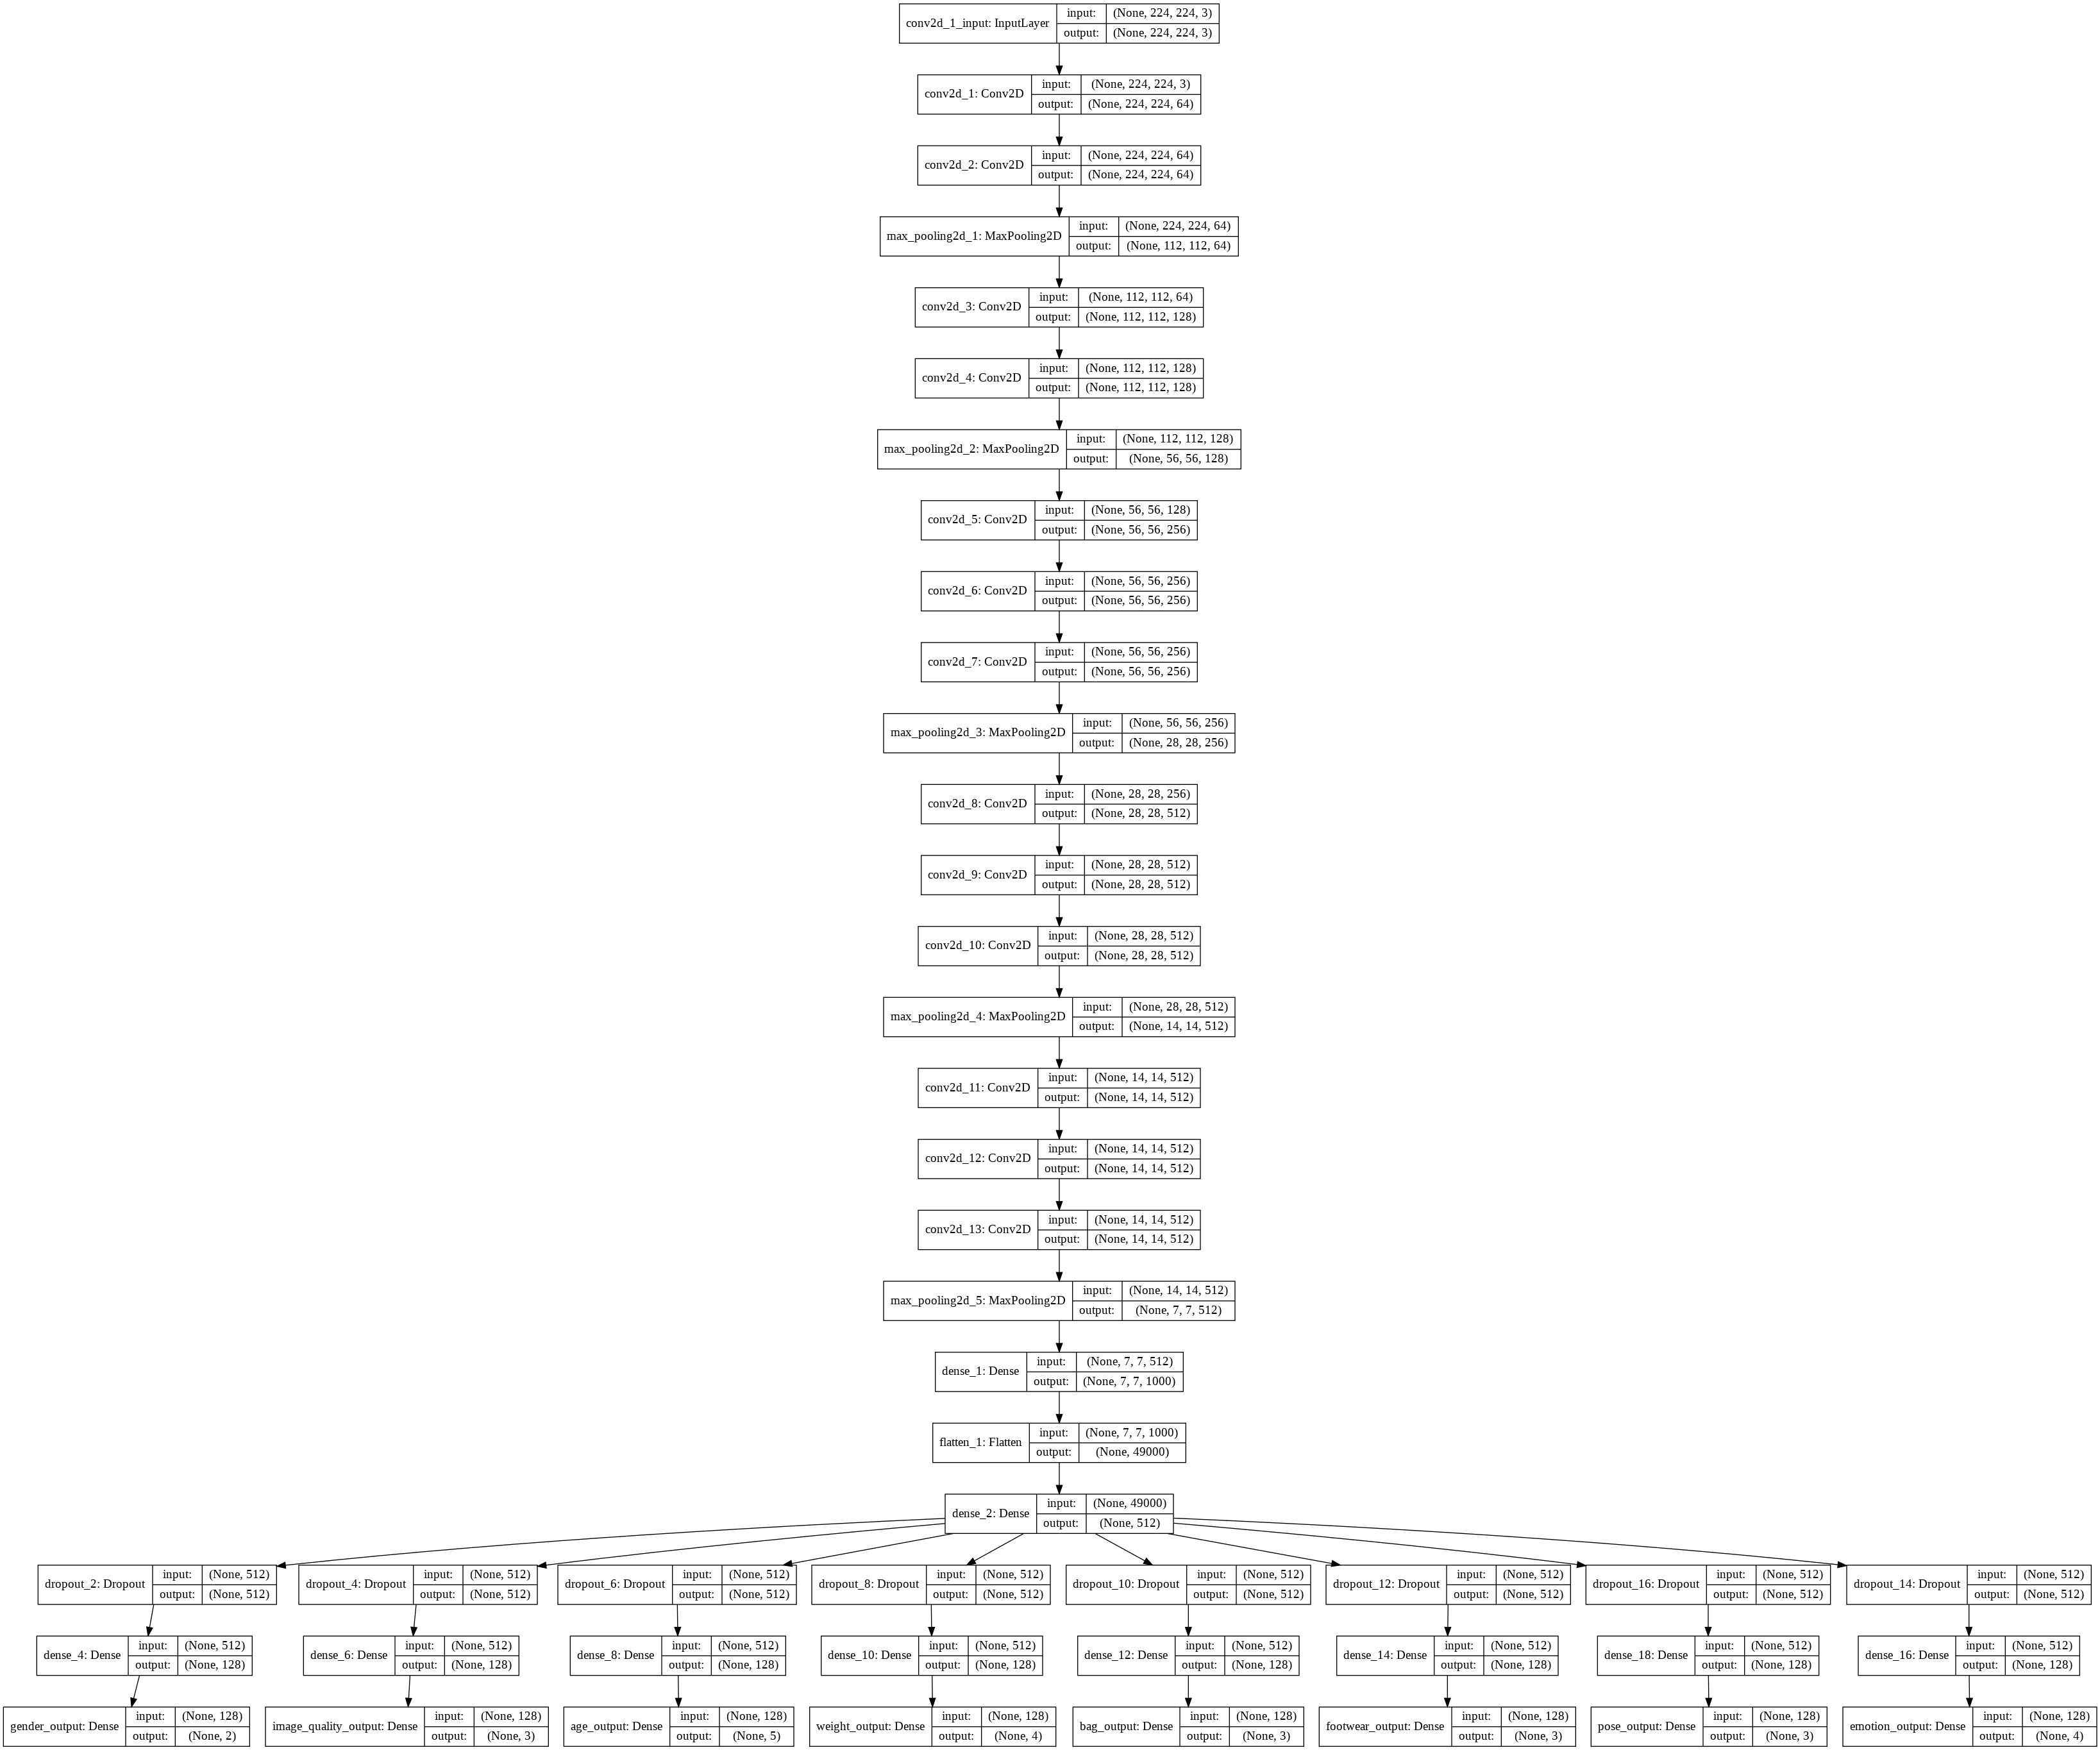

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)